<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/MY_AGENT_IS_MY_DOCTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [36]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

In [37]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('langchain')

In [38]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm.invoke("assalamualyum , i m hafiz naveed uddin , how r u?")

AIMessage(content="Assalamu alaykum Hafiz Naveed Uddin! I hope you are well.  As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d7174d3d-9eb5-4b42-abd7-e2bb7f1c17a2-0', usage_metadata={'input_tokens': 19, 'output_tokens': 59, 'total_tokens': 78, 'input_token_details': {'cache_read': 0}})

In [40]:
# Define Tools for Healthcare Chatbot
def provide_health_tips(symptom: str) -> str:
    """
    Provides basic health tips based on the given symptom.

    Args:
        symptom: A string describing the user's symptom.

    Returns:
        A string containing health tips.
    """
    health_tips = {
        "fever": "Stay hydrated, rest, and take paracetamol as prescribed.",
        "cough": "Drink warm fluids, avoid cold drinks, and try a cough syrup.",
        "headache": "Stay in a quiet room, hydrate, and take over-the-counter painkillers if necessary.",
        "stomach pain": "Avoid spicy food, drink plenty of water, and consider antacids if the pain persists."
    }
    return health_tips.get(symptom.lower(), "I'm sorry, I don't have specific tips for that symptom. Please consult a doctor.")

def calculate_bmi(weight: float, height: float) -> str:
    """
    Calculates the BMI based on weight and height.

    Args:
        weight: Weight in kilograms.
        height: Height in meters.

    Returns:
        A string describing the BMI category.
    """
    bmi = weight / (height ** 2)
    if bmi < 18.5:
        category = "underweight"
    elif 18.5 <= bmi < 24.9:
        category = "normal weight"
    elif 25 <= bmi < 29.9:
        category = "overweight"
    else:
        category = "obesity"
    return f"Your BMI is {bmi:.2f}, which falls under the '{category}' category."


tools = [provide_health_tips,calculate_bmi]


# Bind tools to LLM

llm_with_tools = llm.bind_tools(tools)




In [41]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7af5670fa500>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'provide_health_tips', 'description': 'Provides basic health tips based on the given symptom.', 'parameters': {'properties': {'symptom': {'description': "A string describing the user's symptom.", 'type': 'string'}}, 'required': ['symptom'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'calculate_bmi', 'description': 'Calculates the BMI based on weight and height.', 'parameters': {'properties': {'weight': {'description': 'Weight in kilograms.', 'type': 'number'}, 'height': {'description': 'Height in meters.', 'type': 'number'}}, 'required': ['weight', 'height'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

In [42]:
sys_msg = SystemMessage(content="You are a knowledgeable healthcare assistant. Your goal is to provide helpful health advice, "
        "calculate BMI based on user inputs, and answer healthcare-related questions accurately. Always "
        "respond in a polite and empathetic tone, ensuring that the user feels heard and supported. "
        "For medical emergencies, recommend consulting a doctor.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

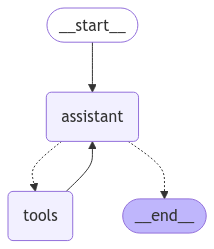

In [43]:
# Graph
builder: StateGraph = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # Now tools is a list of BaseTool objects

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",

    tools_condition,
)
builder.add_edge("tools", "assistant")
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [44]:
config1 = {"configurable": {"thread_id": "1"}}

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?
================================== Ai Message ==================================

Certainly!  I can help you calculate your BMI.
Tool Calls:
  calculate_bmi (30ed8d01-b3ca-46f0-9eae-329f5ac9822c)
 Call ID: 30ed8d01-b3ca-46f0-9eae-329f5ac9822c
  Args:
    height: 1.75
    weight: 70.0
================================= Tool Message =================================
Name: calculate_bmi

Your BMI is 22.86, which falls under the 'normal weight' category.
================================== Ai Message ==================================

Certainly! Based on your provided weight of 70 kg and height of 1.75 meters, your BMI is 22.86. This falls within the normal weight range.  However, it's always a good idea to consult a doctor or healthcare professional for a comprehensive health assessment. They can provide personalized advice based on 

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="My weight is 95 kg, and my height is 5 feet 4 inches. What is my BMI?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?
================================== Ai Message ==================================

Certainly!  I can help you calculate your BMI.
Tool Calls:
  calculate_bmi (30ed8d01-b3ca-46f0-9eae-329f5ac9822c)
 Call ID: 30ed8d01-b3ca-46f0-9eae-329f5ac9822c
  Args:
    height: 1.75
    weight: 70.0
================================= Tool Message =================================
Name: calculate_bmi

Your BMI is 22.86, which falls under the 'normal weight' category.
================================== Ai Message ==================================

Certainly! Based on your provided weight of 70 kg and height of 1.75 meters, your BMI is 22.86. This falls within the normal weight range.  However, it's always a good idea to consult a doctor or healthcare professional for a comprehensive health assessment. They can provide personalized advice based on 

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What should I do to reduce my BMI and maintain a healthy weight?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?
================================== Ai Message ==================================

Certainly!  I can help you calculate your BMI.
Tool Calls:
  calculate_bmi (30ed8d01-b3ca-46f0-9eae-329f5ac9822c)
 Call ID: 30ed8d01-b3ca-46f0-9eae-329f5ac9822c
  Args:
    height: 1.75
    weight: 70.0
================================= Tool Message =================================
Name: calculate_bmi

Your BMI is 22.86, which falls under the 'normal weight' category.
================================== Ai Message ==================================

Certainly! Based on your provided weight of 70 kg and height of 1.75 meters, your BMI is 22.86. This falls within the normal weight range.  However, it's always a good idea to consult a doctor or healthcare professional for a comprehensive health assessment. They can provide personalized advice based on 

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="Can you suggest a diet plan to help me lose weight?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?
================================== Ai Message ==================================

Certainly!  I can help you calculate your BMI.
Tool Calls:
  calculate_bmi (30ed8d01-b3ca-46f0-9eae-329f5ac9822c)
 Call ID: 30ed8d01-b3ca-46f0-9eae-329f5ac9822c
  Args:
    height: 1.75
    weight: 70.0
================================= Tool Message =================================
Name: calculate_bmi

Your BMI is 22.86, which falls under the 'normal weight' category.
================================== Ai Message ==================================

Certainly! Based on your provided weight of 70 kg and height of 1.75 meters, your BMI is 22.86. This falls within the normal weight range.  However, it's always a good idea to consult a doctor or healthcare professional for a comprehensive health assessment. They can provide personalized advice based on 

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What are the risks of having a high BMI?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?
================================== Ai Message ==================================

Certainly!  I can help you calculate your BMI.
Tool Calls:
  calculate_bmi (30ed8d01-b3ca-46f0-9eae-329f5ac9822c)
 Call ID: 30ed8d01-b3ca-46f0-9eae-329f5ac9822c
  Args:
    height: 1.75
    weight: 70.0
================================= Tool Message =================================
Name: calculate_bmi

Your BMI is 22.86, which falls under the 'normal weight' category.
================================== Ai Message ==================================

Certainly! Based on your provided weight of 70 kg and height of 1.75 meters, your BMI is 22.86. This falls within the normal weight range.  However, it's always a good idea to consult a doctor or healthcare professional for a comprehensive health assessment. They can provide personalized advice based on 

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What foods should I avoid to manage my weight better?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Can you calculate my BMI if my weight is 70 kg and my height is 1.75 meters?
================================== Ai Message ==================================

Certainly!  I can help you calculate your BMI.
Tool Calls:
  calculate_bmi (30ed8d01-b3ca-46f0-9eae-329f5ac9822c)
 Call ID: 30ed8d01-b3ca-46f0-9eae-329f5ac9822c
  Args:
    height: 1.75
    weight: 70.0
================================= Tool Message =================================
Name: calculate_bmi

Your BMI is 22.86, which falls under the 'normal weight' category.
================================== Ai Message ==================================

Certainly! Based on your provided weight of 70 kg and height of 1.75 meters, your BMI is 22.86. This falls within the normal weight range.  However, it's always a good idea to consult a doctor or healthcare professional for a comprehensive health assessment. They can provide personalized advice based on 

In [ ]:
config2 = {"configurable": {"thread_id": "2"}}

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="My daughter Fatima Zehra is 5 years old, but she is very weak. What should I do? I had her checked up, and everything is normal, but she is still weak.")]},config2)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

My daughter Fatima Zehra is 5 years old, but she is very weak. What should I do? I had her checked up, and everything is normal, but she is still weak.
================================== Ai Message ==================================

I understand your concern about your daughter Fatima Zehra. It's natural to be worried when a child isn't as strong as expected, even if medical tests show no immediate problems.  Since her check-up revealed everything to be normal, her weakness might stem from other factors.

Here are some things you could consider:

* **Nutrition:** Ensure Fatima Zehra's diet is balanced and includes plenty of fruits, vegetables, and protein.  A well-nourished child is usually stronger.  Consider consulting a nutritionist for a personalized dietary plan.

* **Activity Level:** While she's only 5, moderate physical activity is beneficial.  Encourage age-appropriate play and activities to hel

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What foods should I avoid for Fatima Zehra that could harm her health?")]},config2)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

My daughter Fatima Zehra is 5 years old, but she is very weak. What should I do? I had her checked up, and everything is normal, but she is still weak.
================================== Ai Message ==================================

I understand your concern about your daughter Fatima Zehra. It's natural to be worried when a child isn't as strong as expected, even if medical tests show no immediate problems.  Since her check-up revealed everything to be normal, her weakness might stem from other factors.

Here are some things you could consider:

* **Nutrition:** Ensure Fatima Zehra's diet is balanced and includes plenty of fruits, vegetables, and protein.  A well-nourished child is usually stronger.  Consider consulting a nutritionist for a personalized dietary plan.

* **Activity Level:** While she's only 5, moderate physical activity is beneficial.  Encourage age-appropriate play and activities to hel

In [45]:
config3 = {"configurable": {"thread_id": "3"}}

In [46]:
messages = graph.invoke({"messages": [HumanMessage(content="My name is Hafiz Naveed Uddin, and I am 35 years old. I have a fatty liver issue. What should I do?")]},config3)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

My name is Hafiz Naveed Uddin, and I am 35 years old. I have a fatty liver issue. What should I do?
================================== Ai Message ==================================

Hello, Hafiz Naveed Uddin. I understand you're 35 and have been diagnosed with a fatty liver.  It's important to address this issue with your doctor for proper diagnosis and treatment.  However, I can offer some general advice that might be helpful while you consult a medical professional.

A fatty liver can often be improved through lifestyle changes.  These typically include:

* **Diet:**  Focus on a balanced diet low in saturated and trans fats, refined sugars, and processed foods.  Increase your intake of fruits, vegetables, and whole grains.  Your doctor or a registered dietitian can provide more specific dietary recommendations.

* **Exercise:** Regular physical activity is crucial. Aim for at least 150 minutes of modera

In [47]:
messages = graph.invoke({"messages": [HumanMessage(content="What lifestyle changes should I adopt to reduce fatty liver?")]},config3)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

My name is Hafiz Naveed Uddin, and I am 35 years old. I have a fatty liver issue. What should I do?
================================== Ai Message ==================================

Hello, Hafiz Naveed Uddin. I understand you're 35 and have been diagnosed with a fatty liver.  It's important to address this issue with your doctor for proper diagnosis and treatment.  However, I can offer some general advice that might be helpful while you consult a medical professional.

A fatty liver can often be improved through lifestyle changes.  These typically include:

* **Diet:**  Focus on a balanced diet low in saturated and trans fats, refined sugars, and processed foods.  Increase your intake of fruits, vegetables, and whole grains.  Your doctor or a registered dietitian can provide more specific dietary recommendations.

* **Exercise:** Regular physical activity is crucial. Aim for at least 150 minutes of modera

In [48]:
messages = graph.invoke({"messages": [HumanMessage(content="How much exercise is recommended for fatty liver management?")]},config3)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

My name is Hafiz Naveed Uddin, and I am 35 years old. I have a fatty liver issue. What should I do?
================================== Ai Message ==================================

Hello, Hafiz Naveed Uddin. I understand you're 35 and have been diagnosed with a fatty liver.  It's important to address this issue with your doctor for proper diagnosis and treatment.  However, I can offer some general advice that might be helpful while you consult a medical professional.

A fatty liver can often be improved through lifestyle changes.  These typically include:

* **Diet:**  Focus on a balanced diet low in saturated and trans fats, refined sugars, and processed foods.  Increase your intake of fruits, vegetables, and whole grains.  Your doctor or a registered dietitian can provide more specific dietary recommendations.

* **Exercise:** Regular physical activity is crucial. Aim for at least 150 minutes of modera

In [50]:
messages = graph.invoke({"messages": [HumanMessage(content="What are the common symptoms of a fatty liver?")]},config3)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

My name is Hafiz Naveed Uddin, and I am 35 years old. I have a fatty liver issue. What should I do?
================================== Ai Message ==================================

Hello, Hafiz Naveed Uddin. I understand you're 35 and have been diagnosed with a fatty liver.  It's important to address this issue with your doctor for proper diagnosis and treatment.  However, I can offer some general advice that might be helpful while you consult a medical professional.

A fatty liver can often be improved through lifestyle changes.  These typically include:

* **Diet:**  Focus on a balanced diet low in saturated and trans fats, refined sugars, and processed foods.  Increase your intake of fruits, vegetables, and whole grains.  Your doctor or a registered dietitian can provide more specific dietary recommendations.

* **Exercise:** Regular physical activity is crucial. Aim for at least 150 minutes of modera